Exploratory Data Analysis

In [ ]:
!!pip install adapter-transformers==1.0.1
!git clone https://github.com/huggingface/transformers
!python transformers/utils/download_glue_data.py --tasks RTE

Cloning into 'transformers'...
remote: Enumerating objects: 67173, done.
remote: Total 67173 (delta 0), reused 0 (delta 0), pack-reused 67173
Receiving objects: 100% (67173/67173), 50.04 MiB | 30.09 MiB/s, done.
Resolving deltas: 100% (47743/47743), done.
Traceback (most recent call last):
  File "transformers/utils/download_glue_data.py", line 154, in <module>
    sys.exit(main(sys.argv[1:]))
  File "transformers/utils/download_glue_data.py", line 150, in main
    download_and_extract(task, args.data_dir)
  File "transformers/utils/download_glue_data.py", line 50, in download_and_extract
    urllib.request.urlretrieve(TASK2PATH[task], data_file)
  File "/usr/lib/python3.7/urllib/request.py", line 247, in urlretrieve
    with contextlib.closing(urlopen(url, data)) as fp:
  File "/usr/lib/python3.7/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/usr/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File 

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import pandas as pd
import re
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig, BertForTokenClassification
from torch.optim import Adam
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from tqdm import tqdm,trange
from sklearn.model_selection import train_test_split
torch.__version__
import csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
FILE_PATH =  "drive/MyDrive/Sunidhi-entity_recognition"
TRAIN_FILE = FILE_PATH + "/train.txt"
TEST_FILE = FILE_PATH + "/test.txt"
col_names = ["Tokens","IOB_Tags"]
train_data = pd.read_csv(TRAIN_FILE, sep = '\t', names = col_names,encoding = "ISO-8859-1")
train_data

,Tokens,IOB_Tags
0,@paulwalk,O
1,It,O
2,'s,O
3,the,O
4,view,O
...,...,...
57888,39,O
57889,GMT+0000,O
57890,(,O
57891,UTC,O


In [ ]:
test_data = pd.read_csv(TEST_FILE, header = None, delimiter="\t", names = ['Tokens'], quoting=csv.QUOTE_NONE, encoding='utf-8')
test_data

,Tokens
0,&
1,gt
2,;
3,*
4,The
...,...
23389,with
23390,this
23391,dress
23392,code


**We can see here that we have 13 IOB tags here. It is important to note that one of the tags is 'nan'.**

In [ ]:
train_data['IOB_Tags'].unique()

array(['O', 'B-location', 'I-location', nan, 'B-group', 'B-corporation',
       'B-person', 'B-creative-work', 'B-product', 'I-person',
       'I-creative-work', 'I-corporation', 'I-group', 'I-product'],
      dtype=object)

In [ ]:
train_data.isnull().sum()

Tokens      2168
IOB_Tags    2162
dtype: int64

**We can observe that there are 55731 IOB tags in this document, out of which as we already observed there are 13 unique tags. Let us try to plot and see the distribution of these numbers of tags as well to observe how well are they distributed.**

In [ ]:
train_data.describe()

,Tokens,IOB_Tags
count,55725,55731
unique,13794,13
top,.,O
freq,1777,53003


**Filling in the Na values in the train_data**

In [ ]:
input_data = train_data.fillna(method="ffill")

**Assigning the read file to a variable called content.**

In [ ]:
f = open(TRAIN_FILE, 'r') 
content = f.read()

In [ ]:
print(content)

@paulwalk	O
It	O
's	O
the	O
view	O
from	O
where	O
I	O
'm	O
living	O
for	O
two	O
weeks	O
.	O
Empire	B-location
State	I-location
Building	I-location
=	O
ESB	B-location
.	O
Pretty	O
bad	O
storm	O
here	O
last	O
evening	O
.	O
	
From	O
Green	O
Newsfeed	O
:	O
AHFA	B-group
extends	O
deadline	O
for	O
Sage	O
Award	O
to	O
Nov	O
.	O
5	O
http://tinyurl.com/24agj38	O
	
Pxleyes	B-corporation
Top	O
50	O
Photography	O
Contest	O
Pictures	O
of	O
August	O
2010	O
...	O
http://bit.ly/bgCyZ0	O
#photography	O
	
today	O
is	O
my	O
last	O
day	O
at	O
the	O
office	O
.	O
	
4Dbling	B-person
's	O
place	O
til	O
monday	O
,	O
party	O
party	O
party	O
.	O
&lt;	O
3	O
	
watching	O
the	O
VMA	B-creative-work
pre-show	O
again	O
lol	O
it	O
was	O
n't	O
even	O
a	O
good	O
show	O
the	O
first	O
time	O
...	O
so	O
bored	O
!	O
	
27	O
followers	O
!	O
30	O
followers	O
is	O
my	O
goal	O
for	O
today	O
!	O
	
This	O
is	O
the	O
2nd	O
hospital	O
ive	O
been	O
in	O
today	O
,	O
but	O
ive	O
just	O
seen	O
a	O
doctor	O
who	O
was	O
an	O
older	O
versio

**Splitting the data using regex and then removing any None values from a and appending them into a new list of tokens**

In [ ]:
a = re.split("\s|(?<!\d)[,.](?!\d)", content)
tokenx = []
for i in a:
#     print(i)
    if (i != None):
        tokenx.append(i)
    else:
        continue

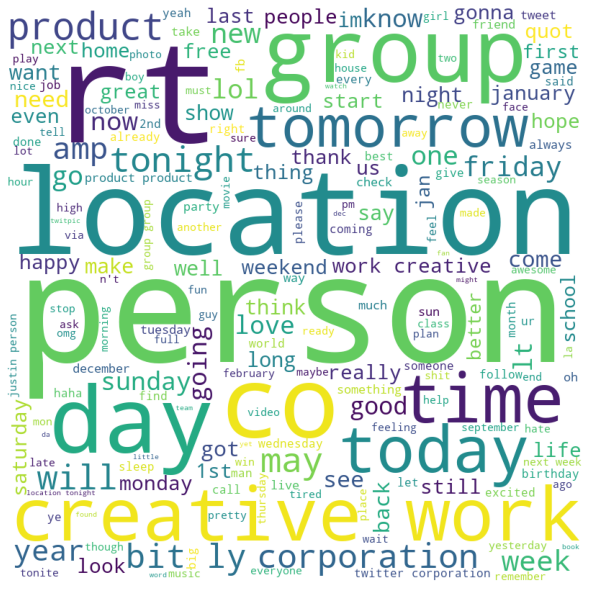

In [ ]:
# Comparing wordclouds for different categories
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

words1 = ''
for i in range(len(new_a)):
    new_a[i] = new_a[i].lower()
words1 += " ".join(new_a)+" "

from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(words1) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

#BERT MODEL FOR THE MULTICLASS CLASSIFICATION PROBLEM

In [ ]:
df = pd.read_csv(TRAIN_FILE, delimiter = "\t")
df.columns = ['Word', 'Tag']
df = df.fillna(method="ffill")
df['Pos'] =""
df['Sentence #'] = ""
sentence_counter = 1
pos_counter = 1
counter = 0
for i in df['Word']:
  df.at[counter, 'Sentence #'] = sentence_counter
  df.at[counter, 'Pos'] = pos_counter
  counter = counter + 1
  pos_counter = pos_counter + 1
  if i == '.':
    sentence_counter = sentence_counter+1
    pos_counter = 1

In [ ]:
df.head(30)

,Word,Tag,Pos,Sentence #
0,It,O,1,1
1,'s,O,2,1
2,the,O,3,1
3,view,O,4,1
4,from,O,5,1
5,where,O,6,1
6,I,O,7,1
7,'m,O,8,1
8,living,O,9,1
9,for,O,10,1


**Constructing sentences out of the tokens in the dataset, which will be tokenized to be used in BERT Tokenizer. **

In [ ]:
class GetSentence(object):
  def __init__(self, data):
    self.n_sent = 1
    self.data = data
    self.empty = False
    function = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(), s["Pos"].values.tolist(), s["Tag"].values.tolist())]
    self.grouped = self.data.groupby("Sentence #").apply(function)
    self.sentences = [s for s in self.grouped]

  def retrieve(self):
    try:
      s = self.grouped["Sentence: {}".format(self.n_sent)]
      self.n_sent += 1
      return s
    except:
      print("Something went wrong")

In [ ]:
sentences = GetSentence(df)
sentences

In [ ]:
Sentences_list = [" ".join([s[0] for s in sent]) for sent in sentences.sentences]
Sentences_list

["It 's the view from where I 'm living for two weeks .",
 'Empire State Building = ESB .',
 'Pretty bad storm here last evening .',
 '.',
 'From Green Newsfeed : AHFA extends deadline for Sage Award to Nov .',
 '5 http://tinyurl.com/24agj38 http://tinyurl.com/24agj38 Pxleyes Top 50 Photography Contest Pictures of August 2010 ... http://bit.ly/bgCyZ0 #photography #photography today is my last day at the office .',
 '.',
 "4Dbling 's place til monday , party party party .",
 "&lt; 3 3 watching the VMA pre-show again lol it was n't even a good show the first time ... so bored ! ! 27 followers ! 30 followers is my goal for today ! ! This is the 2nd hospital ive been in today , but ive just seen a doctor who was an older version of justin :' ) ) Friday Night Eats http://twitpic.com/2pdvtr http://twitpic.com/2pdvtr Gotta dress up for london fashion week and party in style ! ! @Suzie55 whispering cause I may have had 1 too many vodka 's last night and am a lil fragile , hold me ? ? #NFL Week

In [ ]:
len(Sentences_list)

2135

In [ ]:
tags2vals = list(set(df["Tag"].values))
tag2idx = {t: i for i, t in enumerate(tags2vals)}

In [ ]:
tags2vals

['I-creative-work',
 'O',
 'B-location',
 'I-group',
 'B-person',
 'B-creative-work',
 'B-corporation',
 'B-product',
 'I-person',
 'I-product',
 'B-group',
 'I-location',
 'I-corporation']

**tag2idx are the index numbers which get assigned randomly. When we would use our model on the test data, we would observe that the numerical value that each token from test data gets after passing through the model is close to one of the index values, which in turn would be the predicted tag, assigned to the tokens in the test set**

In [ ]:
tag2idx

{'B-corporation': 6,
 'B-creative-work': 5,
 'B-group': 10,
 'B-location': 2,
 'B-person': 4,
 'B-product': 7,
 'I-corporation': 12,
 'I-creative-work': 0,
 'I-group': 3,
 'I-location': 11,
 'I-person': 8,
 'I-product': 9,
 'O': 1}

In [ ]:
labels = [[s[2] for s in sent] for sent in sentences.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
max_seq_len = 200 # tokens
batch_s = 32 # batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0) 

'Tesla T4'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in Sentences_list]
print(tokenized_texts[1])


['empire', 'state', 'building', '=', 'es', '##b', '.']


In [ ]:
X = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=max_seq_len, dtype="long", truncating="post", padding="post")
Y = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=max_seq_len, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
tags2vals = list(set(df["Tag"].values))
tag2idx = {t: i for i, t in enumerate(tags2vals)}

In [ ]:
tags2vals

['I-creative-work',
 'O',
 'B-location',
 'I-group',
 'B-person',
 'B-creative-work',
 'B-corporation',
 'B-product',
 'I-person',
 'I-product',
 'B-group',
 'I-location',
 'I-corporation']

In [ ]:
tag2idx

{'B-corporation': 6,
 'B-creative-work': 5,
 'B-group': 10,
 'B-location': 2,
 'B-person': 4,
 'B-product': 7,
 'I-corporation': 12,
 'I-creative-work': 0,
 'I-group': 3,
 'I-location': 11,
 'I-person': 8,
 'I-product': 9,
 'O': 1}

In [ ]:
X

array([[1122,  112,  188, ...,    0,    0,    0],
       [8207, 1352, 1459, ...,    0,    0,    0],
       [2785, 2213, 4162, ...,    0,    0,    0],
       ...,
       [1380, 4020, 1110, ...,    0,    0,    0],
       [ 180, 1964, 1775, ...,    0,    0,    0],
       [1142, 1110,  170, ...,    0,    0,    0]])

In [ ]:
attention_masks = [[float(i>0) for i in ii] for ii in X]

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, 
                                                            random_state=20, test_size=0.3)
Mask_train, Mask_valid, _, _ = train_test_split(attention_masks, X,
                                             random_state=20, test_size=0.3)

In [ ]:
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)
Y_train = torch.tensor(Y_train)
Y_valid = torch.tensor(Y_valid)
Mask_train = torch.tensor(Mask_train)
Mask_valid = torch.tensor(Mask_valid)

In [ ]:
data_train = TensorDataset(X_train, Mask_train, Y_train)
data_train_sampler = RandomSampler(data_train)
DL_train = DataLoader(data_train, sampler=data_train_sampler, batch_size=batch_s)

data_valid = TensorDataset(X_valid, Mask_valid, Y_valid)
data_valid_sampler = SequentialSampler(data_valid)
DL_valid = DataLoader(data_valid, sampler=data_valid_sampler, batch_size=batch_s)

In [ ]:
model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(tag2idx))

In [ ]:
model = model.to(device)

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

In [ ]:
#from seqeval.metrics import f1_score
from sklearn.metrics import f1_score
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import numpy as np

In [ ]:
epochs = 3
max_grad_norm = 1.0

for _ in range(epochs):
  model.train();
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  for step, batch in enumerate(DL_train):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    loss = model(b_input_ids, token_type_ids = None, attention_mask = b_input_mask, labels= b_labels)
    loss[0].backward()
    tr_loss += loss[0].item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

    torch.nn.utils.clip_grad_norm_(parameters= model.parameters(), max_norm = max_grad_norm)
    optimizer.step()
    model.zero_grad()
  
  print("Train loss: {}".format(tr_loss/nb_tr_steps))

  model.eval()
  predictions = []
  true_labels = []
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  for batch in DL_valid:
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch

      with torch.no_grad():
          tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                attention_mask=b_input_mask, labels=b_labels)
          logits = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)
          
      logits = logits[0].detach().cpu().numpy()
      predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
      label_ids = b_labels.to('cpu').numpy()
      true_labels.append(label_ids)
      tmp_eval_accuracy = flat_accuracy(logits, label_ids)

      eval_loss += tmp_eval_loss[0].mean().item()
      eval_accuracy += tmp_eval_accuracy

      nb_eval_examples += b_input_ids.size(0)
      nb_eval_steps += 1

  pred_tags = [[tags2vals[p_i] for p_i in p] for p in predictions]
  valid_tags = [[tags2vals[l_ii] for l_ii in l_i] for l in true_labels for l_i in l ]
  print("Validation loss: {}".format(eval_loss/nb_eval_steps))
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Train loss: 0.29533147827741946
Validation loss: 0.18428641229513146
Validation Accuracy: 0.9941145833333332
Train loss: 0.1858626994046759
Validation loss: 0.1758813835192649
Validation Accuracy: 0.9941145833333332
Train loss: 0.17424942505486468
Validation loss: 0.1704828774645215
Validation Accuracy: 0.9941145833333332


**Checking the model's accuracy on the test data**

In [ ]:
test_df = pd.read_csv(TEST_FILE, quoting=csv.QUOTE_NONE, error_bad_lines=False)
test_df.columns = ['Word']
test_df = test_df.fillna(method="ffill")
test_df['Sentence #'] = ""
test_df['Tag'] = ""
test_df

b'Skipping line 22: expected 1 fields, saw 2\nSkipping line 113: expected 1 fields, saw 2\nSkipping line 117: expected 1 fields, saw 2\nSkipping line 143: expected 1 fields, saw 2\nSkipping line 182: expected 1 fields, saw 2\nSkipping line 244: expected 1 fields, saw 2\nSkipping line 287: expected 1 fields, saw 2\nSkipping line 310: expected 1 fields, saw 2\nSkipping line 452: expected 1 fields, saw 2\nSkipping line 462: expected 1 fields, saw 2\nSkipping line 480: expected 1 fields, saw 2\nSkipping line 494: expected 1 fields, saw 2\nSkipping line 533: expected 1 fields, saw 2\nSkipping line 550: expected 1 fields, saw 2\nSkipping line 608: expected 1 fields, saw 2\nSkipping line 707: expected 1 fields, saw 2\nSkipping line 802: expected 1 fields, saw 2\nSkipping line 825: expected 1 fields, saw 2\nSkipping line 845: expected 1 fields, saw 2\nSkipping line 921: expected 1 fields, saw 2\nSkipping line 945: expected 1 fields, saw 2\nSkipping line 948: expected 1 fields, saw 2\nSkipping 

,Word,Sentence #,Tag
0,gt,,
1,;,,
2,*,,
3,The,,
4,soldier,,
...,...,...,...
22933,with,,
22934,this,,
22935,dress,,
22936,code,,


In [ ]:
class GetSentence1(object):
  def __init__(self, data):
    self.n_sent = 1
    self.data = data
    self.empty = False
    function = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(), s["Tag"].values.tolist())]
    self.grouped = self.data.groupby("Sentence #").apply(function)
    self.sentences = [s for s in self.grouped]

  def retrieve(self):
    try:
      s = self.grouped["Sentence: {}".format(self.n_sent)]
      self.n_sent += 1
      return s
    except:
      print("Something went wrong")

In [ ]:
test_df.head(70)

,Word,Sentence #,Tag,Pos
0,gt,1,,1
1,;,1,,2
2,*,1,,3
3,The,1,,4
4,soldier,1,,5
...,...,...,...,...
65,on,3,,7
66,Thursday,3,,8
67,recovered,3,,9
68,the,3,,10


In [ ]:
test_sentences = GetSentence1(test_df)
Test_Sentences_list = [" ".join([s[0] for s in sent]) for sent in test_sentences.sentences]
Test_Sentences_list

['gt ; * The soldier was killed when another avalanche hit an army barracks in the northern area of Sonmarg said a military spokesman .',
 '& gt ; * Police last week evacuated 80 villagers from Waltengoo Nar where dozens were killed after a series of avalanches hit the area in 2005 in the south of the territory .',
 '& gt ; * The army on Thursday recovered the bodies of ten of its men who were killed in an avalanche the previous day .',
 '& gt ; * The four civilians killed included two children of a family whose house was hit by a separate avalanche also on Wednesday a police spokesman said .',
 'The bodies of the soldiers were recovered after the concerted efforts of the Avalanche Rescue Teams ( ART ) which is equipped to work in inhospitable terrain and weather conditions .',
 '& gt ; * Arrangements are in place to carry the mortal remains of the martyrs to their native places immediately after weather becomes clear Defence Spokesman Colonel Rajesh Kalia said .',
 'Visuals of the ava

In [ ]:
test_tokenized_texts = [tokenizer.tokenize(sent) for sent in Test_Sentences_list]
print(test_tokenized_texts[1])

['&', 'g', '##t', ';', '*', 'police', 'last', 'week', 'evacuated', '80', 'villagers', 'from', 'wa', '##lten', '##go', '##o', 'na', '##r', 'where', 'dozens', 'were', 'killed', 'after', 'a', 'series', 'of', 'a', '##val', '##anche', '##s', 'hit', 'the', 'area', 'in', '2005', 'in', 'the', 'south', 'of', 'the', 'territory', '.']


In [ ]:
Test_X = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in test_tokenized_texts],
                          maxlen=max_seq_len, dtype="long", truncating="post", padding="post")
Test_X = torch.tensor(Test_X)
test_attention_masks = [[float(i>0) for i in ii] for ii in Test_X]
test_attention_masks = torch.tensor(test_attention_masks)
data_test = TensorDataset(Test_X, test_attention_masks)
data_test_sampler = SequentialSampler(data_test)
DL_Test = DataLoader(data_test, sampler= data_test_sampler, batch_size = batch_s)

**Evaluating the model and checking the output. Here the output is a list of a list and we acquire the output at 0,2 index**

In [ ]:
model.eval()
predictions = []
for batch in DL_Test:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch

  with torch.no_grad():
    output = model(b_input_ids, attention_mask= b_input_mask)
  print(output[0][2])
  break
  
print(predictions)

tensor([[-0.4316,  5.4039,  0.4081,  ..., -0.3431, -0.1879, -2.0874],
        [-0.4304,  5.3873,  0.4787,  ..., -0.3474, -0.2060, -2.1515],
        [-0.4253,  5.4557,  0.3758,  ..., -0.3464, -0.2226, -2.1291],
        ...,
        [-0.7074,  6.6412,  0.1980,  ..., -0.3730, -0.4882, -2.0052],
        [-0.7001,  6.6621,  0.1840,  ..., -0.3765, -0.4868, -1.9833],
        [-0.6788,  6.6477,  0.1803,  ..., -0.3812, -0.4812, -2.0166]],
       device='cuda:0')
[]


**The following output represents the output for one token, where we have 13 buckets because we have 13 Tags. Now if the values are observed: The list has both positive as well as negative values. The greatest value in the list gives us the tag for that token. In this case, we see 4.8793 as the greatest value, which when referred to tag2idx would be closest to B-person as B-person has tag2idx value of 4.**

In [ ]:
 print(output[0][2][2])

tensor([-0.5000,  4.8793,  0.3699, -0.7567,  0.8742, -0.8787, -0.6295, -1.2881,
        -0.1303, -0.7471, -0.1840,  0.0652, -1.7129], device='cuda:0')


**Converting the index values back to Tags values**

In [ ]:
def get_key(val):
    for key, value in tag2idx.items():
        if val == value:
            return key

t=output[0][2].tolist()
pred=[]
for i in t:
    n=int(max(i))
    if n<12:
        pred.append(get_key(n))
    elif n<0:
        n=0
        pred.append(get_key(n))

In [ ]:
pred

['B-creative-work',
 'B-person',
 'B-person',
 'B-person',
 'B-creative-work',
 'B-creative-work',
 'B-creative-work',
 'B-creative-work',
 'B-creative-work',
 'B-creative-work',
 'B-creative-work',
 'B-creative-work',
 'B-creative-work',
 'B-creative-work',
 'B-creative-work',
 'B-creative-work',
 'B-creative-work',
 'B-creative-work',
 'B-creative-work',
 'B-creative-work',
 'B-creative-work',
 'B-creative-work',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-corporation',
 'B-c

**We need to make sure the output is detached from GPU to CPU**

In [ ]:
model.eval()
predictions = []
for batch in DL_Test:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch

  new_tokens = []
  with torch.no_grad():
    output = model(b_input_ids, attention_mask= b_input_mask)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])

In [ ]:
# test_sentence = "It 's the view from where I 'm living in New York for two weeks ."
for  i in Test_Sentences_list:
  tokenized_sentence = tokenizer.encode(i)
  input_ids = torch.tensor([tokenized_sentence]).cuda()
  with torch.no_grad():
      output = model(input_ids)
  label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
  tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])

**We can finally see the predicted labels for the tokens in the test Data**

In [ ]:
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tags2vals[label_idx])
        new_tokens.append(token)
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	pelicans
O	offence
O	could
O	be
O	horrible
O	today
O	unless
O	holiday
O	has
O	a
O	big
O	game
O	and
O	we
O	hit
O	jumpers
O	@
O	kenyeahmonae
O	it
O	'
O	s
O	my
O	school
O	fault
O	girl
O	they
O	cutting
O	up
O	with
O	this
O	dress
O	code
O	[UNK]
O	[SEP]


**Due to the class imbalance issue, 90% of the data was biased towards 'O' tag, which means that the accuracy prediction is also not as accurate. It is rather overfitting in this case because the bias is very high. Hence, I have also tried implementing a NN implementation to handle class imbalance in the data.**